In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

# 1. Create Data for Toy Problem

Assume that at every 10th element there is a little extra added to the series
Question: Can an RNN fit this?


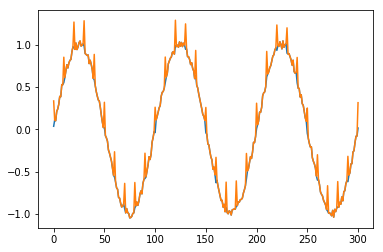

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 150
f = toy_problem(T)
plt.plot(f)
f[0::10] = f[0::10] + 0.3
plt.plot(f)
print('Assume that at every 10th element there is a little extra added to the series')
print('Question: Can an RNN fit this?')

# Setup configuration dictionary


In [3]:
def udic(x, ux):
    x.update(ux)
    return x



In [ ]:
%%timeit -n 1 -r 1
print('x')

In [ ]:
%%timeit -n 1 -r 1
config_dic = {'wx':10, 'ybar':'full', 'epochs':1000, 'type':'CNTRIB_LSTM'}

def run_lstm_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # INPUT GATE
    Ui = tfM([n_hidden, wx], 'Ui') 
    Wi = tfM([n_hidden, n_hidden], 'Wi')
    Vi = tfM([n_hidden, n_hidden], 'Vi')
    bi = tfB([n_hidden], 'bi')
    # OUTPUT GATE
    Uo = tfM([n_hidden, wx], 'Uo') 
    Wo = tfM([n_hidden, n_hidden], 'Wo')
    Vo = tfM([n_hidden, n_hidden], 'Vo')
    bo = tfB([n_hidden], 'bo')
    # FORGET GATE
    Uf = tfM([n_hidden, wx], 'Uf') 
    Wf = tfM([n_hidden, n_hidden], 'Wf')
    Vf = tfM([n_hidden, n_hidden], 'Vf')
    bf = tfB_forget([n_hidden], 'bf')
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    h_prev = tf.zeros([n_hidden], dtype=tf.float32)
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*h_prev, axis=1) + ba)
        f_i = tf.sigmoid(tfrs(Uf*x[:, i]) + tfrs(Wf*h_prev) + tfrs(Vf*c_prev) + bf)
        i_i = tf.sigmoid(tfrs(Ui*x[:, i]) + tfrs(Wi*h_prev) + tfrs(Vi*c_prev) + bi)
        c_i = i_i*a_i + f_i*c_prev
        o_i = tf.sigmoid(tfrs(Uo*x[:, i]) + tfrs(Wo*h_prev) + tfrs(Vo*c_i) + bo)
        h_i = o_i * tf.tanh(c_i)
        hlist.append(h_i)
        clist.append(c_i)
        h_prev = hlist[-1]
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')
    return 'train_fig'+ config_str + '.png'

0.522264
0.518274
0.0793732
0.0673821
0.0609601
0.0573816
0.0551666
0.0536029
0.0523661
0.0513094
0.0503639
0.0494958
0.0486866
0.0479256
0.0472058
0.0465223
0.0458716
0.0452509
0.0446577
0.04409
0.0435461
0.0430244
0.0425236
0.0420424
0.0415795
0.041134
0.0407049
0.0402912
0.0398921
0.0395068
0.0391346
0.0387748
0.0384269
0.0380901
0.0377641
0.0374481
0.0371418
0.0368448
0.0365565
0.0362766
0.0360048
0.0357406
0.0354837
0.0352339
0.0349907
0.034754
0.0345235
0.0342989
0.03408
0.0338666
0.0336584
0.0334553
0.0332571
0.0330635
0.0328744
0.0326897
0.0325092
0.0323327
0.03216
0.0319912
0.031826
0.0316642
0.0315059
0.0313508
0.0311989
0.0310501
0.0309042
0.0307612
0.030621
0.0304835
0.0303485
0.0302161
0.0300862
0.0299586
0.0298334
0.0297103
0.0295895
0.0294707
0.029354
0.0292393
0.0291265
0.0290156
0.0289066
0.0287993
0.0286937
0.0285898
0.0284876
0.0283869
0.0282878
0.0281902
0.0280941
0.0279994
0.0279061
0.0278142
0.0277236
0.0276343
0.0275462
0.0274594
0.0273737
0.0272893
0.027206
0.02

0.0131434
0.0131422
0.013141
0.0131398
0.0131385
0.0131373
0.0131361
0.0131349
0.0131337
0.0131324
0.0131312
0.01313
0.0131288
0.0131276
0.0131264
0.0131251
0.0131239
0.0131227
0.0131215
0.0131203
0.0131191
0.0131179
0.0131166
0.0131154
0.0131142
0.013113
0.0131118
0.0131106
0.0131094
0.0131082
0.013107
0.0131058
0.0131045
0.0131033
0.0131021
0.0131009
0.0130997
0.0130985
0.0130973
0.0130961
0.0130949
0.0130937
0.0130925
0.0130913
0.0130901
0.0130889
0.0130877
0.0130865
0.0130853
0.0130841
0.0130828
0.0130816
0.0130804
0.0130792
0.013078
0.0130768
0.0130756
0.0130744
0.0130732
0.013072
0.0130708
0.0130697
0.0130685
0.0130673
0.0130661
0.0130649
0.0130637
0.0130625
0.0130613
0.0130601
0.0130589
0.0130577
0.0130565
0.0130553
0.0130541
0.0130529
0.0130517
0.0130505
0.0130493
0.0130481
0.013047
0.0130458
0.0130446
0.0130434
0.0130422
0.013041
0.0130398
0.0130386
0.0130374
0.0130362
0.013035
0.0130339
0.0130327
0.0130315
0.0130303
0.0130291
0.0130279
0.0130267
0.0130255
0.0130244
0.0130232


0.00716389
0.00716315
0.00716242
0.00716169
0.00716097
0.00716025
0.00715953
0.00715881
0.0071581
0.00715739
0.00715668
0.00715598
0.00715528
0.00715457
0.00715388
0.00715319
0.0071525
0.00715181
0.00715112
0.00715044
0.00714976
0.00714908
0.00714841
0.00714773
0.00714706
0.00714639
0.00714573
0.00714506
0.0071444
0.00714375
0.00714309
0.00714244
0.00714179
0.00714114
0.0071405
0.00713985
0.00713921
0.00713857
0.00713794
0.00713731
0.00713667
0.00713605
0.00713542
0.00713479
0.00713417
0.00713355
0.00713294
0.00713232
0.0071317
0.0071311
0.00713049
0.00712988
0.00712928
0.00712867
0.00712807
0.00712748
0.00712688
0.00712629
0.0071257
0.00712511
0.00712452
0.00712394
0.00712335
0.00712277
0.00712219
0.00712162
0.00712104
0.00712047
0.0071199
0.00711933
0.00711876
0.0071182
0.00711764
0.00711708
0.00711652
0.00711596
0.00711541
0.00711485
0.0071143
0.00711375
0.0071132
0.00711266
0.00711211
0.00711157
0.00711103
0.00711049
0.00710995
0.00710942
0.00710889
0.00710836
0.00710783
0.0071073


0.00869885
0.00869895
0.00869905
0.00869915
0.00869924
0.00869934
0.00869942
0.00869951
0.0086996
0.00869968
0.00869976
0.00869985
0.00869992
0.0087
0.00870007
0.00870014
0.00870021
0.00870028
0.00870034
0.0087004
0.00870046
0.00870052
0.00870058
0.00870063
0.00870068
0.00870073
0.00870078
0.00870082
0.00870087
0.00870091
0.00870095
0.00870098
0.00870102
0.00870105
0.00870108
0.00870111
0.00870114
0.00870116
0.00870118
0.0087012
0.00870122
0.00870124
0.00870125
0.00870126
0.00870127
0.00870128
0.00870129
0.00870129
0.00870129
0.00870129
0.00870129
0.00870128
0.00870128
0.00870127
0.00870126
0.00870125
0.00870123
0.00870122
0.0087012
0.00870118
0.00870115
0.00870113
0.0087011
0.00870107
0.00870104
0.00870101
0.00870098
0.00870094
0.0087009
0.00870086
0.00870082
0.00870078
0.00870073
0.00870068
0.00870063
0.00870058
0.00870053
0.00870047
0.00870041
0.00870035
0.00870029
0.00870023
0.00870016
0.0087001
0.00870003
0.00869996
0.00869988
0.00869981
0.00869973
0.00869965
0.00869957
0.00869949

0.00853291
0.00852939
0.00852601
0.00852275
0.00851962
0.00851661
0.00851372
0.00851095
0.00850829
0.00850574
0.0085033
0.00850096
0.00849873
0.0084966
0.00849456
0.00849262
0.00849077
0.00848901
0.00848734
0.00848575
0.00848425
0.00848283
0.00848148
0.00848021
0.00847902
0.0084779
0.00847685
0.00847586
0.00847495
0.00847409
0.0084733
0.00847257
0.0084719
0.00847128
0.00847072
0.00847022
0.00846976
0.00846936
0.008469
0.00846869
0.00846843
0.00846821
0.00846803
0.00846789
0.0084678
0.00846774
0.00846772
0.00846773
0.00846778
0.00846786
0.00846797
0.00846812
0.00846829
0.00846849
0.00846872
0.00846898
0.00846926
0.00846957
0.0084699
0.00847025
0.00847063
0.00847102
0.00847144
0.00847187
0.00847232
0.00847279
0.00847328
0.00847378
0.0084743
0.00847483
0.00847537
0.00847593
0.0084765
0.00847709
0.00847768
0.00847828
0.0084789
0.00847952
0.00848016
0.0084808
0.00848145
0.0084821
0.00848277
0.00848344
0.00848411
0.00848479
0.00848548
0.00848617
0.00848687
0.00848757
0.00848827
0.00848898
0.

0.00830832
0.00830711
0.00830589
0.00830467
0.00830344
0.00830221
0.00830097
0.00829973
0.00829848
0.00829723
0.00829597
0.00829471
0.00829344
0.00829217
0.00829089
0.00828961
0.00828832
0.00828703
0.00828573
0.00828443
0.00828312
0.0082818
0.00828049
0.00827916
0.00827783
0.0082765
0.00827516
0.00827381
0.00827246
0.00827111
0.00826975
0.00826838
0.00826701
0.00826563
0.00826425
0.00826286
0.00826147
0.00826007
0.00825866
0.00825725
0.00825584
0.00825442
0.00825299
0.00825156
0.00825012
0.00824868
0.00824723
0.00824578
0.00824432
0.00824285
0.00824138
0.0082399
0.00823842
0.00823693
0.00823544
0.00823394
0.00823243
0.00823092
0.00822941
0.00822788
0.00822636
0.00822482
0.00822328
0.00822174
0.00822019
0.00821863
0.00821707
0.0082155
0.00821393
0.00821235
0.00821076
0.00820917
0.00820757
0.00820597
0.00820436
0.00820275
0.00820113
0.0081995
0.00819787
0.00819623
0.00819459
0.00819294
0.00819128
0.00818962
0.00818796
0.00818628
0.0081846
0.00818292
0.00818123
0.00817954
0.00817784
0.008

0.0132776
0.0132763
0.0132751
0.0132738
0.0132726
0.0132713
0.0132701
0.0132688
0.0132676
0.0132663
0.0132651
0.0132639
0.0132626
0.0132614
0.0132601
0.0132589
0.0132576
0.0132564
0.0132551
0.0132539
0.0132527
0.0132514
0.0132502
0.0132489
0.0132477
0.0132465
0.0132452
0.013244
0.0132427
0.0132415
0.0132402
0.013239
0.0132378
0.0132365
0.0132353
0.013234
0.0132328
0.0132316
0.0132303
0.0132291
0.0132279
0.0132266
0.0132254
0.0132241
0.0132229
0.0132217
0.0132204
0.0132192
0.013218
0.0132167
0.0132155
0.0132142
0.013213
0.0132118
0.0132105
0.0132093
0.0132081
0.0132068
0.0132056
0.0132044
0.0132031
0.0132019
0.0132007
0.0131994
0.0131982
0.013197
0.0131957
0.0131945
0.0131933
0.013192
0.0131908
0.0131896
0.0131883
0.0131871
0.0131859
0.0131846
0.0131834
0.0131822
0.0131809
0.0131797
0.0131785
0.0131772
0.013176
0.0131748
0.0131736
0.0131723
0.0131711
0.0131699
0.0131686
0.0131674
0.0131662
0.0131649
0.0131637
0.0131625
0.0131613
0.01316
0.0131588
0.0131576
0.0131563
0.0131551
0.0131539


0.00722334
0.00722238
0.00722143
0.00722049
0.00721955
0.00721861
0.00721767
0.00721673
0.0072158
0.00721488
0.00721395
0.00721303
0.00721211
0.00721119
0.00721028
0.00720937
0.00720846
0.00720755
0.00720665
0.00720575
0.00720485
0.00720395
0.00720306
0.00720217
0.00720128
0.0072004
0.00719951
0.00719864
0.00719776
0.00719689
0.00719602
0.00719515
0.00719428
0.00719342
0.00719256
0.0071917
0.00719084
0.00718999
0.00718914
0.00718829
0.00718745
0.0071866
0.00718576
0.00718492
0.00718409
0.00718325
0.00718242
0.0071816
0.00718077
0.00717995
0.00717913
0.00717831
0.00717749
0.00717668
0.00717587
0.00717506
0.00717425
0.00717345
0.00717264
0.00717184
0.00717105
0.00717025
0.00716946
0.00716867
0.00716788
0.0071671
0.00716631
0.00716553
0.00716475
0.00716397
0.0071632
0.00716243
0.00716166
0.00716089
0.00716013
0.00715936
0.0071586
0.00715785
0.00715709
0.00715634
0.00715558
0.00715483
0.00715409
0.00715334
0.0071526
0.00715185
0.00715112
0.00715038
0.00714964
0.00714891
0.00714818
0.007147

0.0086067
0.00860673
0.00860677
0.00860681
0.00860686
0.00860691
0.00860697
0.00860703
0.0086071
0.00860717
0.00860725
0.00860733
0.00860742
0.00860751
0.0086076
0.0086077
0.0086078
0.00860791
0.00860801
0.00860812
0.00860824
0.00860835
0.00860847
0.00860859
0.00860872
0.00860885
0.00860897
0.0086091
0.00860924
0.00860937
0.0086095
0.00860964
0.00860978
0.00860992
0.00861007
0.00861021
0.00861035
0.0086105
0.00861064
0.00861079
0.00861093
0.00861108
0.00861123
0.00861138
0.00861153
0.00861167
0.00861182
0.00861197
0.00861212
0.00861227
0.00861241
0.00861256
0.00861271
0.00861286
0.008613
0.00861315
0.00861329
0.00861344
0.00861358
0.00861372
0.00861386
0.00861401
0.00861415
0.00861428
0.00861442
0.00861456
0.00861469
0.00861483
0.00861496
0.0086151
0.00861523
0.00861536
0.00861549
0.00861562
0.00861575
0.00861587
0.008616
0.00861612
0.00861625
0.00861637
0.00861649
0.00861661
0.00861672
0.00861684
0.00861696
0.00861707
0.00861718
0.00861729
0.0086174
0.00861751
0.00861762
0.00861773
0.

0.0445094
0.0329112
0.0249804
0.0198873
0.0167494
0.0148517
0.0136989
0.0129794
0.012509
0.012182
0.0119391
0.0117469
0.0115866
0.0114474
0.0113228
0.0112091
0.011104
0.0110059
0.0109138
0.010827
0.010745
0.0106674
0.0105938
0.0105239
0.0104576
0.0103945
0.0103344
0.0102772
0.0102228
0.0101708
0.0101213
0.010074
0.0100288
0.00998565
0.00994435
0.00990481
0.00986694
0.00983064
0.00979583
0.00976242
0.00973034
0.0096995
0.00966985
0.00964133
0.00961386
0.0095874
0.00956188
0.00953727
0.00951352
0.00949058
0.00946842
0.00944698
0.00942625
0.00940618
0.00938674
0.00936791
0.00934966
0.00933195
0.00931477
0.00929809
0.00928189
0.00926615
0.00925085
0.00923597
0.00922149
0.00920741
0.00919369
0.00918033
0.00916732
0.00915464
0.00914228
0.00913023
0.00911847
0.009107
0.0090958
0.00908487
0.0090742
0.00906378
0.0090536
0.00904365
0.00903393
0.00902443
0.00901514
0.00900606
0.00899718
0.0089885
0.00898001
0.0089717
0.00896357
0.00895562
0.00894784
0.00894023
0.00893277
0.00892548
0.00891834
0.0

0.00857651
0.00857589
0.00857528
0.00857466
0.00857405
0.00857343
0.00857281
0.00857219
0.00857157
0.00857094
0.00857032
0.00856969
0.00856906
0.00856843
0.0085678
0.00856716
0.00856653
0.00856589
0.00856526
0.00856462
0.00856398
0.00856334
0.00856269
0.00856204
0.0085614
0.00856075
0.0085601
0.00855945
0.00855879
0.00855814
0.00855748
0.00855682
0.00855616
0.0085555
0.00855483
0.00855417
0.0085535
0.00855283
0.00855216
0.00855149
0.00855082
0.00855014
0.00854946
0.00854878
0.0085481
0.00854742
0.00854673
0.00854605
0.00854536
0.00854467
0.00854397
0.00854328
0.00854258
0.00854189
0.00854119
0.00854048
0.00853978
0.00853907
0.00853837
0.00853766
0.00853695
0.00853623
0.00853551
0.0085348
0.00853408
0.00853335
0.00853263
0.0085319
0.00853117
0.00853044
0.00852971
0.00852898
0.00852824
0.0085275
0.00852676
0.00852601
0.00852527
0.00852452
0.00852377
0.00852302
0.00852226
0.0085215
0.00852074
0.00851998
0.00851922
0.00851845
0.00851768
0.00851691
0.00851614
0.00851536
0.00851458
0.0085138

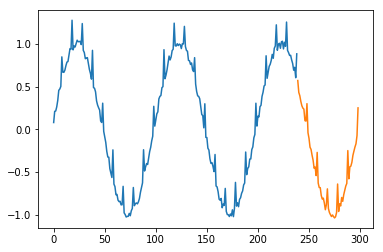

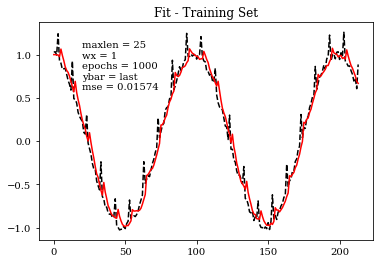

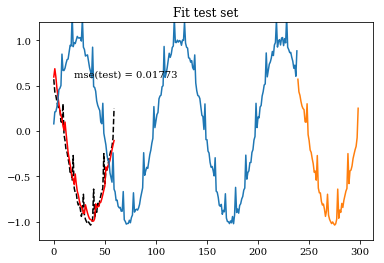

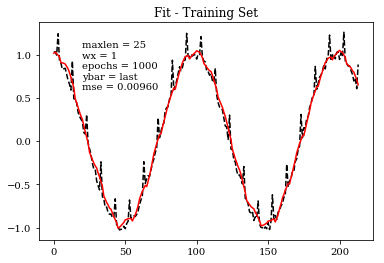

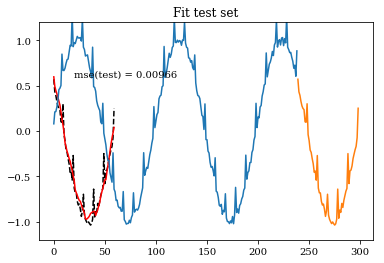

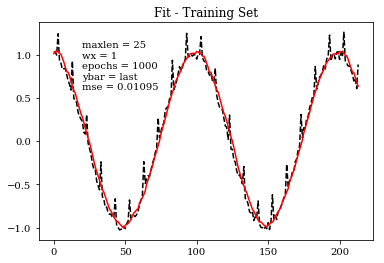

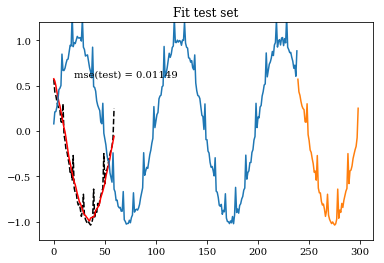

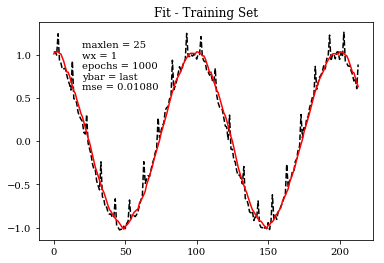

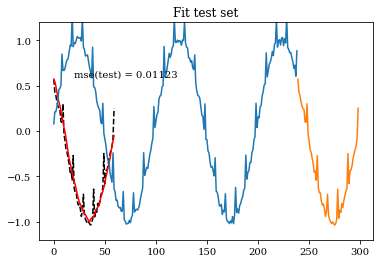

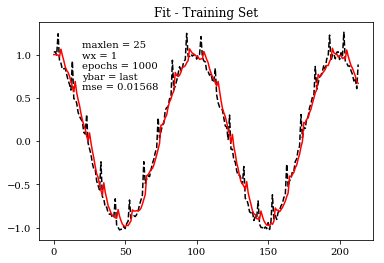

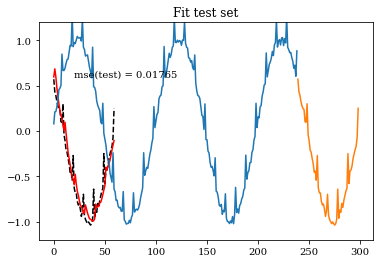

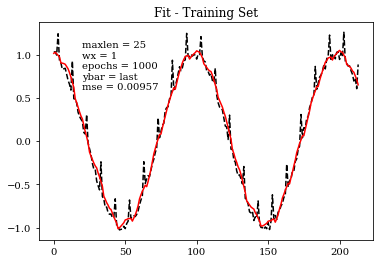

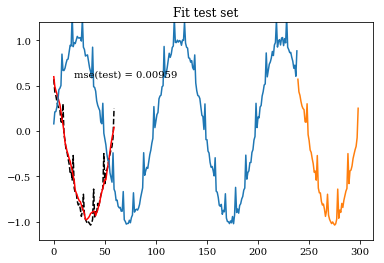

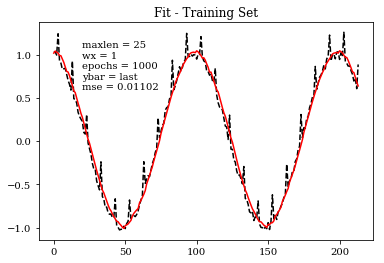

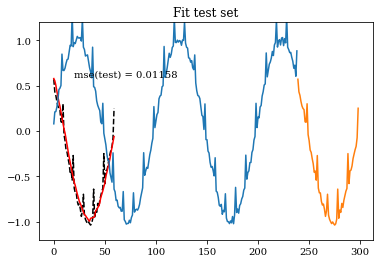

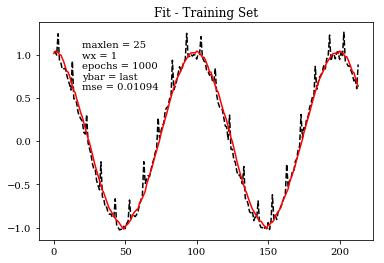

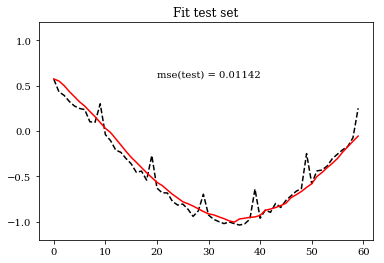

In [8]:
%%timeit -n 1 -r 1
config_dic = {'wx':10, 'ybar':'full', 'epochs':1000, 'type':'LSTM'}


run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'last', 'wx':1}))
run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'last', 'wx':1}))
run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'last', 'wx':1}))
run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'last', 'wx':1}))

#run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'full', 'wx':1}))
#run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'full', 'wx':1}))
#run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'full', 'wx':1}))
#run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'full', 'wx':1}))


run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'last'}))
run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'last'}))
run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'last'}))
run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'last'}))

In [ ]:


run_lstm_model(udic(config_dic, {'type':'LSTM'}))
run_cec_model(udic(config_dic, {'type':'CEC'}))
run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple'}))
run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget'}))

run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'last'}))
run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'last'}))
run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'last'}))
run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'last'}))

#run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'last', 'wx':1}))
#run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'last', 'wx':1}))
#run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'last', 'wx':1}))
#run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'last', 'wx':1}))
#
#run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'full', 'wx':1}))
#run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'full', 'wx':1}))
#run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'full', 'wx':1}))
#run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'full', 'wx':1}))

In [ ]:
run_cec_model(udic(config_dic, {'type':'CEC'}))

In [ ]:
config_dic.update({'type':'LSTA'})
config_dic

In [ ]:
run_lstm_no_forget_model(config_dic)

In [ ]:
run_lstm_simple_model(config_dic)

In [4]:
def run_lstm_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # INPUT GATE
    Ui = tfM([n_hidden, wx], 'Ui') 
    Wi = tfM([n_hidden, n_hidden], 'Wi')
    Vi = tfM([n_hidden, n_hidden], 'Vi')
    bi = tfB([n_hidden], 'bi')
    # OUTPUT GATE
    Uo = tfM([n_hidden, wx], 'Uo') 
    Wo = tfM([n_hidden, n_hidden], 'Wo')
    Vo = tfM([n_hidden, n_hidden], 'Vo')
    bo = tfB([n_hidden], 'bo')
    # FORGET GATE
    Uf = tfM([n_hidden, wx], 'Uf') 
    Wf = tfM([n_hidden, n_hidden], 'Wf')
    Vf = tfM([n_hidden, n_hidden], 'Vf')
    bf = tfB_forget([n_hidden], 'bf')
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    h_prev = tf.zeros([n_hidden], dtype=tf.float32)
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*h_prev, axis=1) + ba)
        f_i = tf.sigmoid(tfrs(Uf*x[:, i]) + tfrs(Wf*h_prev) + tfrs(Vf*c_prev) + bf)
        i_i = tf.sigmoid(tfrs(Ui*x[:, i]) + tfrs(Wi*h_prev) + tfrs(Vi*c_prev) + bi)
        c_i = i_i*a_i + f_i*c_prev
        o_i = tf.sigmoid(tfrs(Uo*x[:, i]) + tfrs(Wo*h_prev) + tfrs(Vo*c_i) + bo)
        h_i = o_i * tf.tanh(c_i)
        hlist.append(h_i)
        clist.append(c_i)
        h_prev = hlist[-1]
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')
    return 'train_fig'+ config_str + '.png'

In [5]:
def run_cec_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*c_prev, axis=1) + ba)
        c_i = a_i + c_prev
        clist.append(c_i)
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in clist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')
    return 'train_fig'+ config_str + '.png'



# Define Graph

In [6]:
def run_lstm_simple_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # INPUT GATE
    Ui = tfM([n_hidden, wx], 'Ui') 
    Wi = tfM([n_hidden, n_hidden], 'Wi')
    bi = tfB([n_hidden], 'bi')
    # OUTPUT GATE
    Uo = tfM([n_hidden, wx], 'Uo') 
    Wo = tfM([n_hidden, n_hidden], 'Wo')
    bo = tfB([n_hidden], 'bo')
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    h_prev = tf.zeros([n_hidden], dtype=tf.float32)
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*h_prev, axis=1) + ba)
        i_i = tf.sigmoid(tfrs(Ui*x[:, i]) + tfrs(Wi*h_prev) + bi)
        c_i = i_i*a_i + c_prev
        o_i = tf.sigmoid(tfrs(Uo*x[:, i]) + tfrs(Wo*h_prev) + bo)
        h_i = o_i * tf.tanh(c_i)
        hlist.append(h_i)
        clist.append(c_i)
        h_prev = hlist[-1]
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')
    return 'train_fig'+ config_str + '.png'

In [7]:
def run_lstm_no_forget_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # INPUT GATE
    Ui = tfM([n_hidden, wx], 'Ui') 
    Wi = tfM([n_hidden, n_hidden], 'Wi')
    Vi = tfM([n_hidden, n_hidden], 'Vi')
    bi = tfB([n_hidden], 'bi')
    # OUTPUT GATE
    Uo = tfM([n_hidden, wx], 'Uo') 
    Wo = tfM([n_hidden, n_hidden], 'Wo')
    Vo = tfM([n_hidden, n_hidden], 'Vo')
    bo = tfB([n_hidden], 'bo')
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    h_prev = tf.zeros([n_hidden], dtype=tf.float32)
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*h_prev, axis=1) + ba)
        i_i = tf.sigmoid(tfrs(Ui*x[:, i]) + tfrs(Wi*h_prev) + tfrs(Vi*c_prev) + bi)
        c_i = i_i*a_i + c_prev
        o_i = tf.sigmoid(tfrs(Uo*x[:, i]) + tfrs(Wo*h_prev) + tfrs(Vo*c_i) + bo)
        h_i = o_i * tf.tanh(c_i)
        hlist.append(h_i)
        clist.append(c_i)
        h_prev = hlist[-1]
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')